# BCQ DDPG 

### Off-Policy Deep Reinforcement Learning without Exploration

I used code from https://github.com/sfujim/BCQ
Arxiv: https://arxiv.org/abs/1812.02900

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [84]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py

def load_file(path, name):
    import importlib.util
    spec = importlib.util.spec_from_file_location(name, path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod

plot = load_file("../../utils/plot.py", "plot")
radam = load_file("../../utils/optim.py", "radam")
data = load_file("../../utils/data.py", "data")
models = load_file("../../utils/models.py", "models")

cuda = torch.device('cuda')

# ---
frame_size = 10
batch_size = 25
# --- 

tqdm.pandas()

In [54]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_ref = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))
movie_ref_tensor, key_to_id, id_to_key = data.make_movie_tensor(movie_ref)
# download ml20m dataset
ratings = pd.read_csv('../../data/ml-20m/ratings.csv')
user_dict, users = data.prepare_tensor(ratings, key_to_id, frame_size)
del ratings
gc.collect

<function gc.collect(generation=2)>

In [85]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

%matplotlib inline 

from jupyterthemes import jtplot
jtplot.style(theme='monokai')

def run_tests():
    test_batch = next(iter(test_dataloader))
    losses = bcq_update(test_batch, debug=True, learn=False)
    return losses

def plot_losses(value_losses, policy_losses, vae_losses, test=True, smoothing=2, cfg=False):
    global test_losses
    
    if test:
        test_ = run_tests()
        test_losses[0].append(len(value_losses))
        test_losses[1].append(test_[0])
        test_losses[2].append(test_[1])
        test_losses[3].append(test_[2])
        
        
    plt.figure(figsize=(20,5))
    plt.title('vae')
    plt.plot(plot.smooth_gauss(vae_losses, smoothing), label='train')
    plt.plot(test_losses[0], test_losses[3], '-r', label='test')
        
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('value')
    plt.plot(plot.smooth_gauss(value_losses, smoothing), label='train')
    plt.plot(test_losses[0], test_losses[1], label='test')
    plt.legend()
    plt.subplot(132)
    plt.title('policy')
    plt.plot(plot.smooth_gauss(policy_losses, smoothing), label='train')
    plt.plot(test_losses[0], test_losses[2], '-r', label='test')
    plt.legend()
    if cfg:
        plt.suptitle(cfg)
    plt.show()
    

    

In [96]:
# P.S. This is not a usual Actor.
# It is a peturbative network
class Perturbator(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-1):
        super(Perturbator, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        a = torch.cat([state, action], 1)
        a = F.relu(self.linear1(a))
        a = self.drop_layer(a)
        a = F.relu(self.linear2(a))
        a = self.drop_layer(a)
        a = self.linear3(a) 
        return a + action

In [89]:
class Generator(nn.Module):
    def __init__(self, num_inputs, num_actions, latent_dim):
        super(Generator, self).__init__()
        #encoder
        self.e1 = nn.Linear(num_inputs + num_actions, 750)
        self.e2 = nn.Linear(750, 750)

        self.mean = nn.Linear(750, latent_dim)
        self.log_std = nn.Linear(750, latent_dim)
        
        #decoder
        self.d1 = nn.Linear(num_inputs + latent_dim, 750)
        self.d2 = nn.Linear(750, 750)
        self.d3 = nn.Linear(750, num_actions)
        
        self.latent_dim = latent_dim
        self.normal = torch.distributions.Normal(0, 1)


    def forward(self, state, action):
        # z is encoded state + action
        z = F.relu(self.e1(torch.cat([state, action], 1)))
        z = F.relu(self.e2(z))

        mean = self.mean(z)
        # Clamped for numerical stability 
        log_std = self.log_std(z).clamp(-4, 15)
        std = torch.exp(log_std)
        z = mean + std * self.normal.sample(std.size()).to(next(self.parameters()).device)

        # u is decoded action
        u = self.decode(state, z)

        return u, mean, std
    
    def decode(self, state, z=None):
        # When sampling from the VAE, the latent vector is clipped to [-0.5, 0.5]
        if z is None:
            z = self.normal.sample([state.size(0), self.latent_dim])
            z = z.clamp(-0.5, 0.5).to(next(self.parameters()).device)

        a = F.relu(self.d1(torch.cat([state, z], 1)))
        a = F.relu(self.d2(a))
        return self.d3(a)

In [90]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [91]:
# debug logging
def debug_log_error(name, x):
    global debug_dict
    try:
        target = debug_dict['error'][name] 
    except KeyError:
        if name not in debug_dict['error']:
            debug_dict['error'][name] = {}
            target = debug_dict['error'][name] 
            target['std'] = []
            target['mean'] = []
    
    target['std'].append(x.std().item())
    target['mean'].append(x.mean().item())

def debug_log_object(name, x):
    global debug_dict
    debug_dict['obj'][name] = x

In [92]:
def bcq_update(batch, gamma = 0.9, min_value=-np.inf, max_value=np.inf,
           soft_tau=1e-4, n_vae_samples=10, debug=False, learn=True, step=-1):
    
    batch = [i.to(cuda) for i in batch]
    state, action, reward, next_state, done = batch
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    batch_size = done.size(0)
    
    # --------------------------------------------------------#
    # Variational Auto-Encoder Training
    recon, mean, std = vae_net(state, action)
    recon_loss = F.mse_loss(recon, action)
    KL_loss	= -0.5 * (1 + torch.log(std.pow(2)) - mean.pow(2) - std.pow(2)).mean()
    vae_loss = recon_loss + 0.5 * KL_loss
    
    if not learn:
        debug_log_object('recon test', recon)
    if learn:
        debug_log_object('recon', recon)
        debug_log_error('vae_mean', mean)
        debug_log_error('vae_std', std)
        
        vae_optimizer.zero_grad()
        vae_loss.backward()
        vae_optimizer.step()
    # --------------------------------------------------------#
    # Value Learning
    with torch.no_grad():
        # p.s. repeat_interleave was added in torch 1.1
        # if an error pops up, run 'conda update pytorch'
        state_rep = torch.repeat_interleave(next_state, n_vae_samples, 0)
        sampled_action = vae_net.decode(state_rep)
        perturbed_action = target_policy_net(state_rep, sampled_action)
        target_Q1 = target_value_net1(state_rep, perturbed_action)
        target_Q2 = target_value_net1(state_rep, perturbed_action)
        target_value = 0.75 * torch.min(target_Q1, target_Q2) # value soft update
        target_value+= 0.25 * torch.max(target_Q1, target_Q2) #
        target_value = target_value.view(batch_size, -1).max(1)[0].view(-1, 1)
        debug_log_error('target_value ', target_value)
        expected_value = reward + (1.0 - done) * gamma * target_value

    value = value_net1(state, action)
    debug_log_error('value', value)
    value_loss = torch.pow(value - expected_value.detach(), 2).mean()
    
    if learn:
        value_optimizer1.zero_grad()
        value_optimizer2.zero_grad()
        value_loss.backward()
        value_optimizer1.step()
        value_optimizer2.step()
    
    # --------------------------------------------------------#
    # Policy learning
    sampled_actions = vae_net.decode(state)
    perturbed_actions= policy_net(state, sampled_actions)
    policy_loss = -value_net1(state, perturbed_actions).mean()
    
    if not learn:
        debug_log_object('test sampled_actions', sampled_actions)
        debug_log_object('test perturbed_actions', perturbed_actions)
    else:
        debug_log_object('sampled_actions', sampled_actions)
        debug_log_object('perturbed_actions', perturbed_actions)
        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), -1, 1)
        policy_optimizer.step()
        
        soft_update(value_net1, target_value_net1, soft_tau=P_soft_tau)
        soft_update(value_net2, target_value_net2, soft_tau=P_soft_tau)
        soft_update(policy_net, target_policy_net, soft_tau=P_soft_tau)
        
    # --------------------------------------------------------#

    losses = [value_loss.item(), policy_loss.item(), vae_loss.item()]
    
    return losses

In [94]:
# === ddpg settings ===
P_gamma = 0.99
P_min_value=-10
P_max_value=10
P_soft_tau=0.1
P_policy_lr = 1e-5
P_value_lr  = 1e-5
P_policy_step = 3
P_vae_samples = 10

P_cfg = {'gamma': P_gamma, 'min_v': P_min_value, 'max_v':P_max_value,
        'stau': P_soft_tau, 'policy_lr': P_policy_lr, 'value_lr': P_value_lr}
# === end ===

In [97]:
vae_net = Generator(1290, 128, 512).to(cuda)

value_net1  = models.Critic(1290, 128, 256).to(cuda)
value_net2  = models.Critic(1290, 128, 256).to(cuda)
policy_net = Perturbator(1290, 128, 256).to(cuda)

target_value_net1 = models.Critic(1290, 128, 256).to(cuda)
target_value_net2 = models.Critic(1290, 128, 256).to(cuda)
target_policy_net = Perturbator(1290, 128, 256).to(cuda)

target_policy_net.eval()
target_value_net1.eval()
target_value_net2.eval()

soft_update(value_net1, target_value_net1, soft_tau=1.0)
soft_update(value_net2, target_value_net2, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)


# optim.Adam can be replaced with RAdam
value_optimizer1 = optim.Adam(value_net1.parameters(), lr=P_policy_lr, weight_decay=1e-2)
value_optimizer2 = optim.Adam(value_net2.parameters(), lr=P_policy_lr, weight_decay=1e-2)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=P_value_lr, weight_decay=1e-2)
vae_optimizer = optim.Adam(vae_net.parameters())

debug_dict = {'error': {}, 'obj': {}}

In [98]:
value_losses  = []
policy_losses = []
vae_losses    = []
test_losses   = [[], [], [], []]

step = 1
n_epochs = 100
batch_size = 25

epoch_bar = tqdm(total=n_epochs)

test_losses = [[], [], [], []]
train_users = users[:-5000]
test_users = users[-5000:]

def prepare_batch_wrapper(x):
    batch = data.prepare_batch(x, movie_ref_tensor, frame_size=frame_size)
    return batch

train_user_dataset = data.UserDataset(train_users, user_dict)
test_user_dataset = data.UserDataset(test_users, user_dict)
train_dataloader = DataLoader(train_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)
test_dataloader = DataLoader(test_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)

step 260


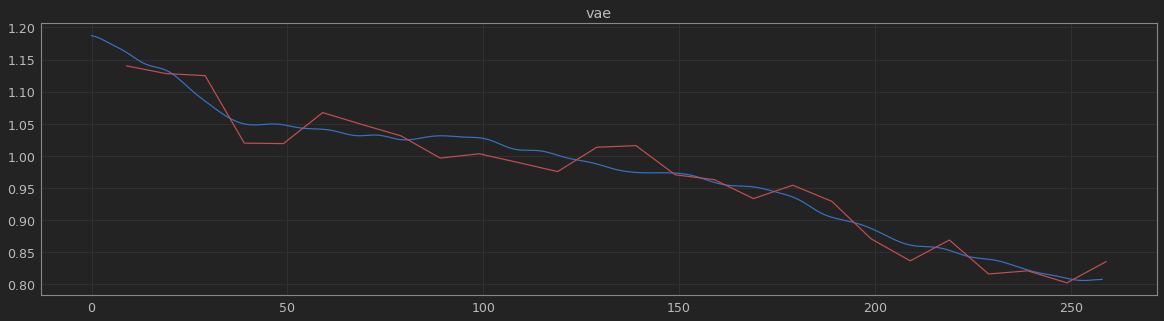

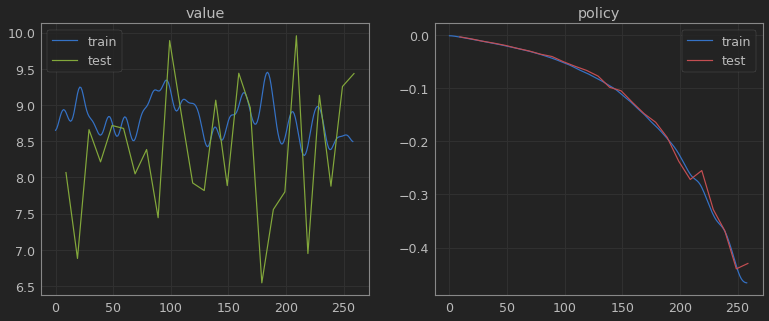

KeyboardInterrupt: 

In [99]:

# --- config ---
DEBUG = True
batch = []
plot_every = 10
# --- end ---
for epoch in range(n_epochs):
    epoch_bar.update(1)
    for batch in tqdm(train_dataloader):
        loss = bcq_update(batch, debug=DEBUG, gamma = P_gamma, min_value=P_min_value,
                    max_value=P_max_value, soft_tau=P_soft_tau,
                    n_vae_samples=P_vae_samples, step=step)
        
        value_losses.append(loss[0])
        policy_losses.append(loss[1])
        vae_losses.append(loss[2])

        step += 1
        if step % plot_every == 0:
            clear_output(True)
            
            print('step', step)
            #if debug_test_gen_action is not None:
            # plot.embed_show(debug_test_gen_action[:50])
            # plot.embed_show(debug_gen_action[:50])
            plot_losses(value_losses, policy_losses, vae_losses,test=True,
                     smoothing=4)

In [ ]:
#torch.save(vae_net.state_dict(), "../../models/BCQ/bcq_vae.pt")
#torch.save(policy_net.state_dict(), "../../models/BCQ/bcq_policy.pt")
#torch.save(value_net1.state_dict(), "../../models/BCQ/bcq_value1.pt")
#torch.save(value_net2.state_dict(), "../../models/BCQ/bcq_value2.pt")

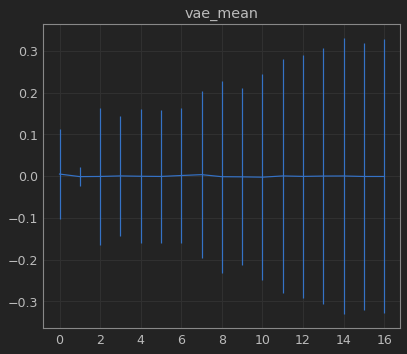

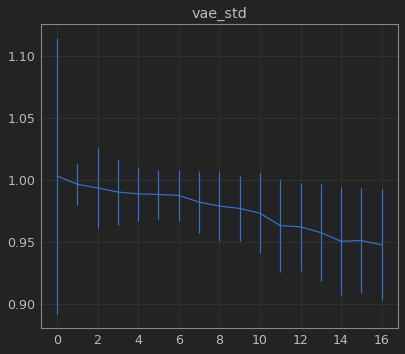

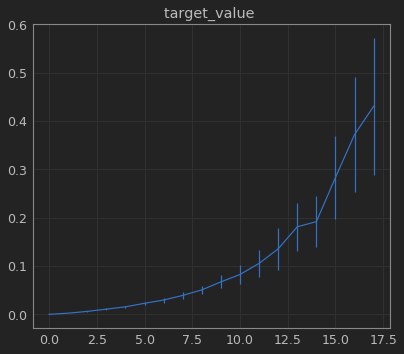

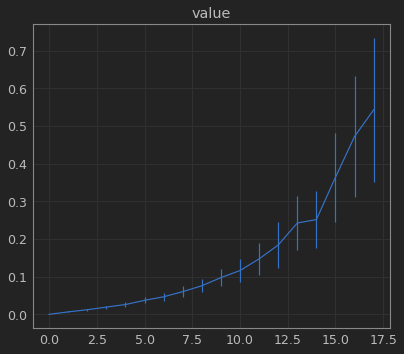

In [100]:
for key, error in debug_dict['error'].items():
    sf = int(np.sqrt(len(error['mean'])))
    plt.errorbar(range(len(error['mean'][::sf])), error['mean'][::sf], error['std'][::sf])
    plt.title(key)
    plt.show()

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


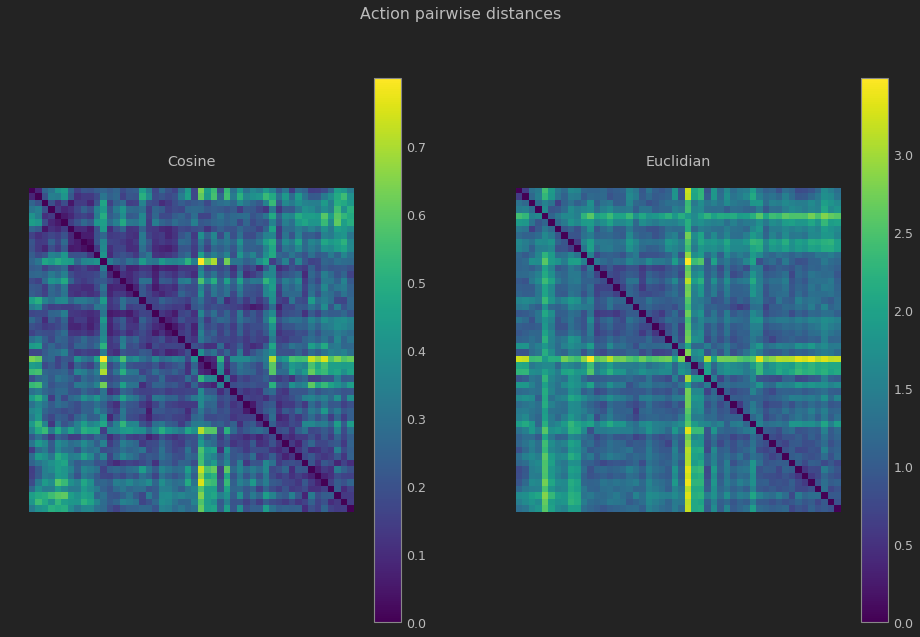

In [101]:
plot.embed_show(debug_dict['obj']['test sampled_actions'][:50])

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


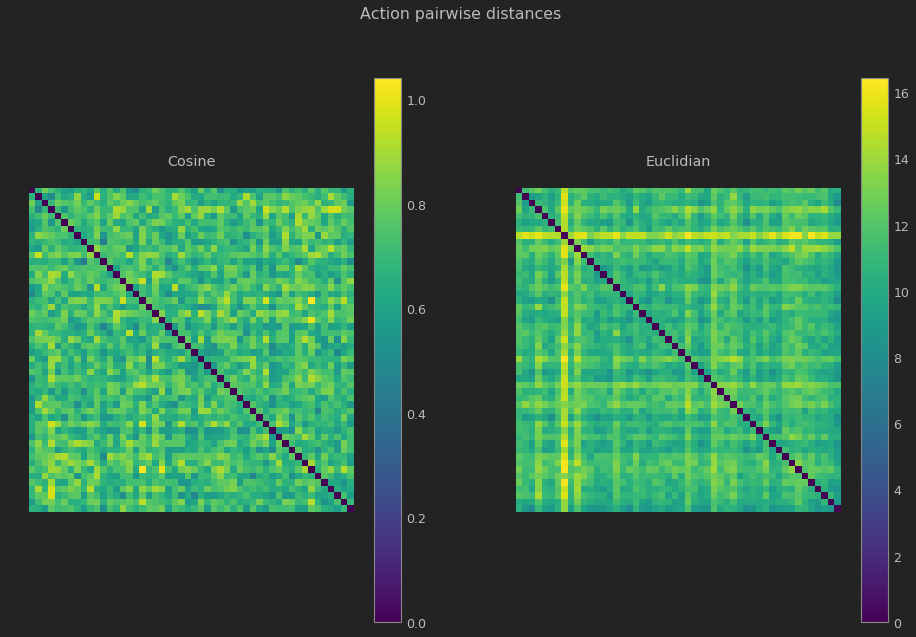

In [102]:
plot.embed_show(debug_dict['obj']['test perturbed_actions'][:50])

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


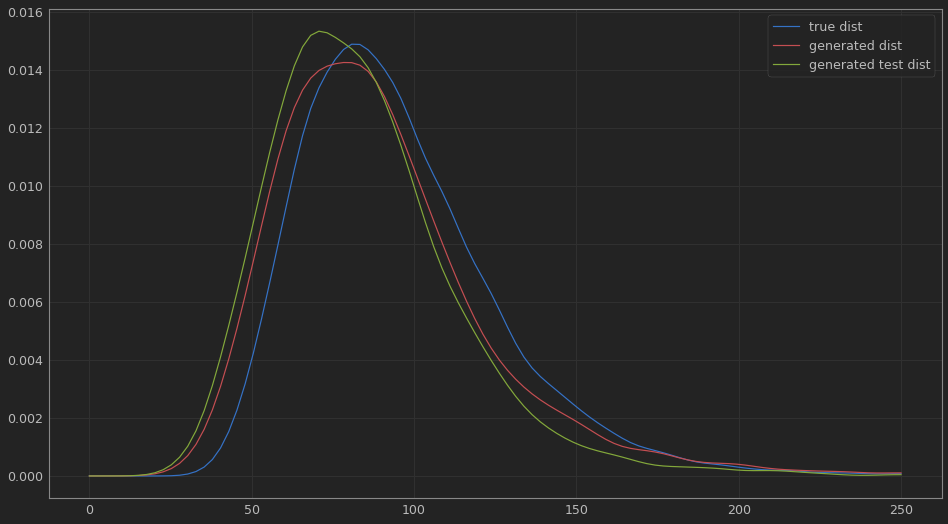

In [103]:

from scipy.special import kl_div
gen_actions = debug_dict['obj']['perturbed_actions']
gen_test_actions = debug_dict['obj']['test perturbed_actions']
true_actions = np.stack([movie_ref[i] for i in movie_ref])


class AnomalyDetector(nn.Module):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.ae = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.ae(x)
    
    def rec_error(self, x):
        error = torch.sum((x - self.ae(x)) ** 2, 1)
        if x.size(1) != 1:
            return error.detach()
        return error.item()
    
ad = AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()

from scipy import stats


true_scores = ad.rec_error(torch.tensor(true_actions).to(cuda).float()).detach().cpu().numpy()
gen_scores = ad.rec_error(torch.tensor(gen_actions).to(cuda).float()).detach().cpu().numpy()
gen_test_scores =ad.rec_error(torch.tensor(gen_test_actions).to(cuda).float()) \
                                                            .detach().cpu().numpy() 

true_kernel = stats.gaussian_kde(true_scores)
gen_kernel = stats.gaussian_kde(gen_scores)
gen_test_kernel = stats.gaussian_kde(gen_test_scores)

x = np.linspace(0,250, 100)
probs_true = true_kernel(x)
probs_gen = gen_kernel(x)
probs_gen_test = gen_test_kernel(x)
plt.figure(figsize=(16, 9))
plt.plot(x, probs_true, '-b', label='true dist')
plt.plot(x, probs_gen, '-r', label='generated dist')
plt.plot(x, probs_gen_test, '-g', label='generated test dist')
plt.legend()
plt.show()